In [2]:
%pip install opendatasets --upgrade --quiet

import opendatasets as od
import os
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# insert ypu kaggle  username and key
od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small',data_dir="dataset")

In [ ]:
df = pd.read_csv('dataset/fashion-product-images-small/styles.csv', on_bad_lines='skip')
df.head()

In [ ]:
sample_df = df.sample(n=2000, random_state=0)
sample_df.head()

In [ ]:
%pip install sweetviz
import sweetviz as sv

In [ ]:
sample_report = sv.analyze(sample_df, pairwise_analysis="on")

In [ ]:
sample_report.show_html(layout='vertical')

### My personal data and model Exploration

In [3]:
# use either small or large dataset
SMALL_DATASET = False

In [4]:
# insert ypu kaggle  username and key
if (SMALL_DATASET):
    od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small',data_dir="dataset")

In [5]:
if (SMALL_DATASET):
    df_data = pd.read_csv("dataset/fashion-product-images-small/styles.csv", on_bad_lines='skip')
    image_files = os.listdir("dataset/fashion-product-images-small/images")
else:
    df_data = pd.read_csv("../input/fashion-product-images-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')
    image_files = os.listdir("../input/fashion-product-images-dataset/fashion-dataset/images")

### Clean Data from nulls and non existing images

In [6]:
df_data.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [7]:
df_data.dropna(inplace=True)

In [8]:
#check if file exists
df_data['file_found'] = df_data['id'].apply(lambda x: f"{x}.jpg" in image_files)

In [9]:
df_data['file_found'].value_counts()

file_found
True     44072
False        5
Name: count, dtype: int64

In [10]:
mask = df_data['file_found']
df_data = df_data[mask].reset_index(drop=True)

### Add paths to images and review dataset

In [11]:
# insert ypu kaggle  username and key
if (SMALL_DATASET):
    df_data['filename'] = df_data['id'].apply(lambda x: os.path.join("dataset/fashion-product-images-small/images/",str(x)+".jpg"))
else:
    df_data['filename'] = df_data['id'].apply(lambda x: os.path.join("../input/fashion-product-images-dataset/fashion-dataset/images/",str(x)+".jpg"))


In [12]:
df_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,file_found,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,True,../input/fashion-product-images-dataset/fashio...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,True,../input/fashion-product-images-dataset/fashio...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,True,../input/fashion-product-images-dataset/fashio...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,True,../input/fashion-product-images-dataset/fashio...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,True,../input/fashion-product-images-dataset/fashio...


In [13]:
#Reduce size of the dataset for test purposes
df_data = df_data.head(2000)

### Convert images to the numpy 3d matrix in order to later use them in the NN.
##### 3d matrix represents width, height and 3 colours

In [14]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

2024-02-08 22:13:16.315064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 22:13:16.315190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 22:13:16.484882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
image_path = df_data['filename'][500]
image = load_img(image_path)
image = img_to_array(image)
image.shape

(1440, 1080, 3)

In [16]:
#normalize images by fixing width and height
if (SMALL_DATASET):
    IMAGE_WIDTH = 60
    IMAGE_HEIGHT = 60
else:
    IMAGE_WIDTH = 250
    IMAGE_HEIGHT = 250

In [17]:
images = []

In [18]:
def process_image(image_path):
    image = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT,3))
    image = img_to_array(image)
    return image

In [19]:
counter = 0
for file_path in df_data['filename']:
    if counter % 1000 == 0:
        print(f"Image {counter} done!")
    images.append(process_image(file_path))
    counter += 1

Image 0 done!
Image 1000 done!


In [20]:
images = np.array(images)

In [21]:
images.shape

(2000, 250, 250, 3)

### Split Dataset and Encode Labels

In [22]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [23]:
#for test purposes let's start with 2 lables
output_lables = ["articleType","baseColour"]

In [24]:
(X_train, X_test, 
 y_train,y_test) = train_test_split(images,df_data[output_lables],
                                                    test_size=0.2, random_state=42)

In [25]:
y_train.head()

,articleType,baseColour
968,Kurta Sets,Pink
240,Casual Shoes,Brown
819,Wallets,Red
692,Handbags,Pink
420,Tshirts,Red


In [26]:
lb_article_type = LabelBinarizer()
lb_colour = LabelBinarizer()

article_type_train = lb_article_type.fit_transform(y_train["articleType"].to_numpy())
colour_train = lb_colour.fit_transform(y_train["baseColour"].to_numpy())

article_type_test = lb_article_type.transform(y_train["articleType"].to_numpy())
colour_test = lb_colour.transform(y_train["baseColour"].to_numpy())

### Create a modell

In [27]:
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense,BatchNormalization, MaxPooling2D, Conv2D, Activation, Input, Flatten,Dropout)

In [28]:
img_inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = Conv2D(32, 3, padding='same', activation='relu')(img_inputs)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

In [29]:
def make_branch(res_input, n_out, name):
    x = Dense(256, activation='relu')(res_input)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(n_out)(x)
    x = Activation("softmax",name=(name + '_output'))(x)
    return x

In [30]:
article_type_branch = make_branch(x, len(lb_article_type.classes_),'article_type')
colour_branch = make_branch(x, len(lb_colour.classes_), 'colour')

In [31]:
model = Model(inputs=img_inputs,outputs=[article_type_branch,colour_branch])

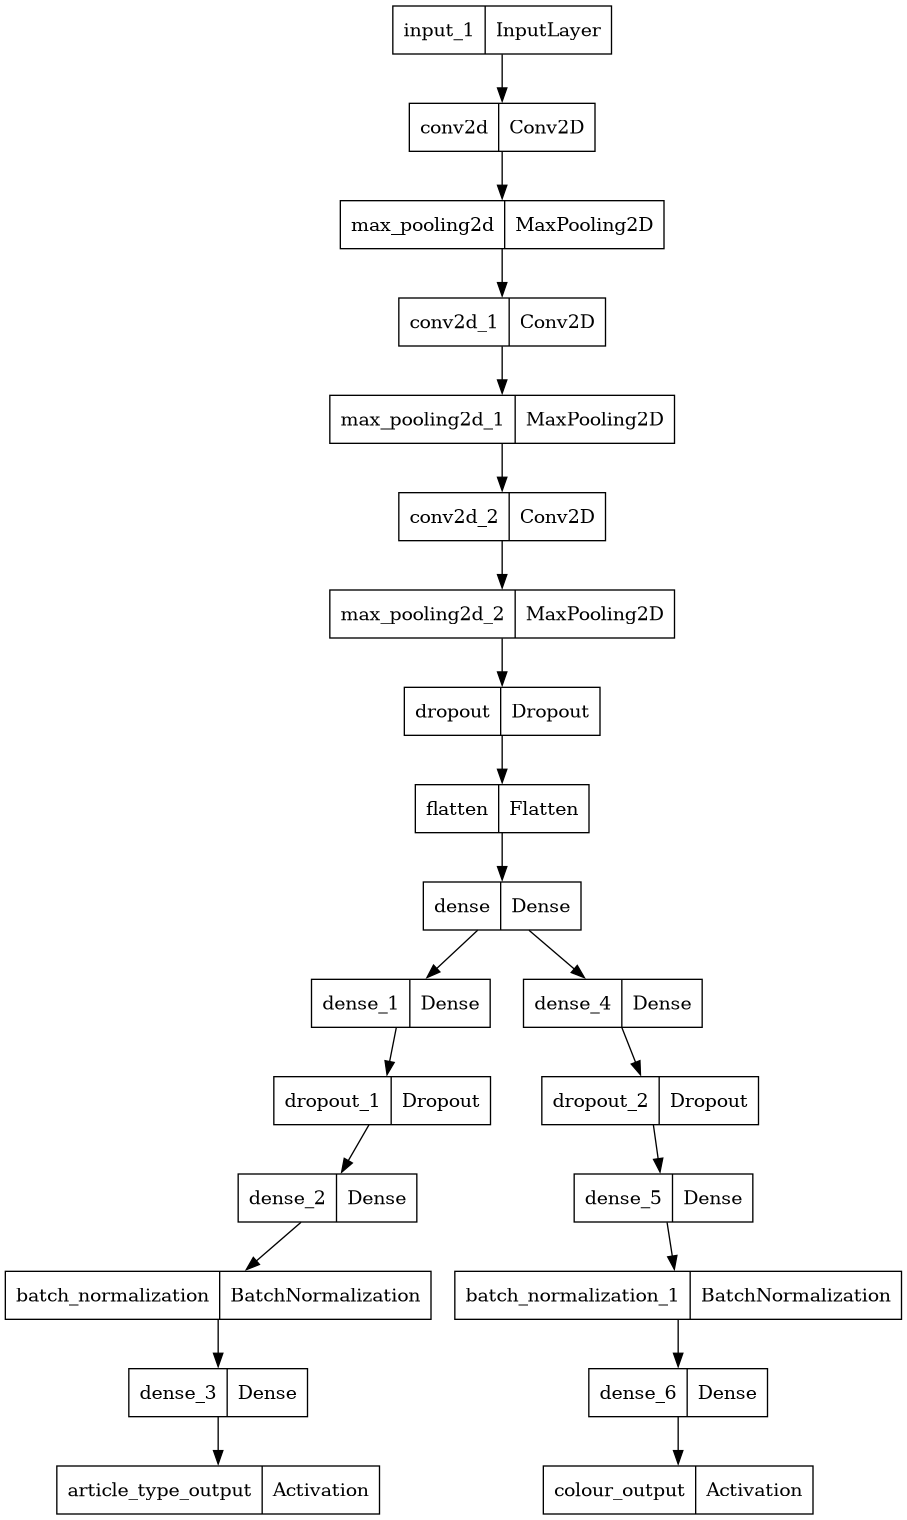

In [32]:
keras.utils.plot_model(model)

In [33]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

### Train and evaluate model

In [35]:
EPOCHS=60
history = model.fit(
    X_train,
    {
        'article_type_output': article_type_train,  
        'colour_output': colour_train
    },
    # validation_data=(
    #     X_test,
    #     {
    #         'article_type_output': y_article_type_test,  
    #         'colour_output': y_colour_test
    #     }
    # ),
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/60
50/50 [==============================] - 6s 112ms/step - loss: 0.0626 - article_type_output_loss: 0.0259 - colour_output_loss: 0.0367 - article_type_output_accuracy: 0.9962 - colour_output_accuracy: 0.9950
Epoch 2/60
50/50 [==============================] - 6s 112ms/step - loss: 0.0539 - article_type_output_loss: 0.0197 - colour_output_loss: 0.0342 - article_type_output_accuracy: 0.9975 - colour_output_accuracy: 0.9937
Epoch 3/60
50/50 [==============================] - 6s 112ms/step - loss: 0.0565 - article_type_output_loss: 0.0151 - colour_output_loss: 0.0414 - article_type_output_accuracy: 1.0000 - colour_output_accuracy: 0.9894
Epoch 4/60
50/50 [==============================] - 6s 113ms/step - loss: 0.0623 - article_type_output_loss: 0.0165 - colour_output_loss: 0.0458 - article_type_output_accuracy: 0.9994 - colour_output_accuracy: 0.9894
Epoch 5/60
50/50 [==============================] - 6s 113ms/step - loss: 0.0542 - article_type_output_loss: 0.0206 - colour_output_

<Axes: >

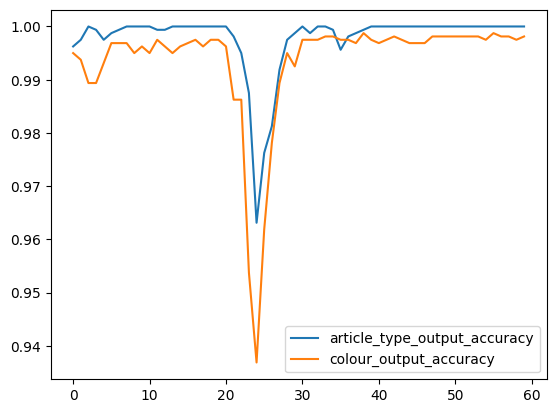

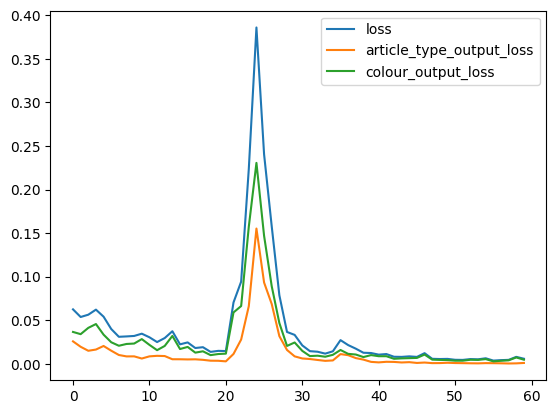

In [36]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,[col for col in history_df.columns if 'accuracy' in col and 'val' not in col]].plot()
history_df.loc[:,[col for col in history_df.columns if 'loss' in col and 'val' not in col]].plot()

In [37]:
image_path = df_data['filename'][500]
input_image = np.expand_dims(process_image(image_path), axis=0)


In [38]:
output = model.predict(input_image)

1/1 [==============================] - 0s 490ms/step


In [39]:
(article_type, colour) = output
article_type = article_type[0].argmax()
colour= colour[0].argmax()
article_type_label = lb_article_type.classes_[article_type]
colour_label = lb_colour.classes_[colour]

In [40]:
import matplotlib.pyplot as plt

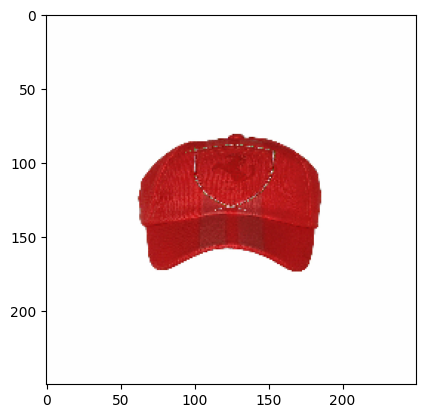

article_type_label: Caps
colour_label: Red


In [43]:
image = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
plt.imshow(image)
plt.show()
print(f"article_type_label: {article_type_label}")
print(f"colour_label: {colour_label}")